In [2]:
import os
import numpy as np
import pandas as pd
from sklearn.cluster import DBSCAN
from sklearn.semi_supervised import LabelPropagation
import matplotlib.pyplot as plt
import openslide

class Patch:
    def __init__(self, x, y, prediction, embedding, probabilities):
        self.x = x
        self.y = y
        self.prediction = prediction
        self.embedding = embedding
        self.probabilities = probabilities

def create_patches_from_parquet(file_path):
    patches = []
    df = pd.read_parquet(file_path)
    
    for _, row in df.iterrows():
        patch = Patch(
            x=row['x'],
            y=row['y'],
            prediction=row['prediction'],
            embedding=row['embedding'],
            probabilities=row['probabilities']
        )
        patches.append(patch)
    
    return patches

def load_patches_from_folder(folder_path):
    all_patches = []
    
    for file_name in os.listdir(folder_path):
        if file_name.endswith('.parquet'):
            file_path = os.path.join(folder_path, file_name)
            patches = create_patches_from_parquet(file_path)
            all_patches.extend(patches)

    print(f"Total patches loaded: {len(all_patches)}")
    return all_patches

def visualize_prediction_map(
    patches, labels, slide_path, level=4, patch_size=224, 
    classes=None, title="Prediction Map", filename=None
):
    slide = openslide.OpenSlide(slide_path)
    slide_img = np.array(slide.read_region((0, 0), level, slide.level_dimensions[level]))[:, :, :3]

    fig, ax = plt.subplots(figsize=(20, 12))
    ax.imshow(slide_img)

    scale_factor = 1
    labels = np.array(labels)

    for patch, label in zip(patches, labels):
        x_lv = patch.x // scale_factor
        y_lv = patch.y // scale_factor
        ps_lv = patch_size // scale_factor

        rect = plt.Rectangle((x_lv, y_lv), ps_lv, ps_lv, linewidth=0.5, edgecolor='cyan', facecolor='none')
        ax.add_patch(rect)

        ax.text(
            x_lv + ps_lv // 2,
            y_lv + ps_lv // 2,
            str(classes[label]) if classes else str(label),
            color='red', fontsize=8, ha='center', va='center', weight='bold'
        )

    ax.set_title(title)
    ax.axis("off")

    if filename:
        plt.savefig(filename, bbox_inches='tight', dpi=300)
        plt.close()
    else:
        plt.show()

def run_visualization_for_all_slides(
    low_res_folder="../../Cytology-fine-tuning/wsi_results_low_res",
    slide_base_path="C:/Users/lucas/AAA_MEMOIRE/Code_Memoire/img/database",
    save_folder="visualisations_lowres",
    classes=["1", "2", "3", "41", "5"],
    level=4,
    patch_size=224
):
    os.makedirs(save_folder, exist_ok=True)

    for image_folder in os.listdir(low_res_folder):
        full_folder_path = os.path.join(low_res_folder, image_folder)

        if not os.path.isdir(full_folder_path):
            continue

        image_name = image_folder
        slide_filename = f"{image_name}.ndpi"
        slide_path = os.path.join(slide_base_path, slide_filename)

        if not os.path.exists(slide_path):
            continue

        print(f"\n Processing {image_name}...")

        # Load patches
        patches = load_patches_from_folder(full_folder_path)
        labels = [patch.prediction for patch in patches]

        output_img = os.path.join(save_folder, f"heatmap_pred_{image_name}.png")
        visualize_prediction_map(
            patches=patches,
            labels=labels,
            slide_path=slide_path,
            level=level,
            patch_size=patch_size,
            classes=classes,
            title=f"Prediction Map - {image_name}",
            filename=output_img
        )
        print(f"Saved visualization: {output_img}")

run_visualization_for_all_slides(
    low_res_folder="../../Cytology-fine-tuning/wsi_results_low_res",
    slide_base_path="C:/Users/lucas/AAA_MEMOIRE/Code_Memoire/img/database",
    save_folder="visualisations_lowres",
    level=4
)


# folder_path = "../../Cytology-fine-tuning/wsi_results_high_res"
# patches = load_patches_from_folder(folder_path)
# labels = [patch.prediction for patch in patches]
# visualize_prediction_map(
#     patches,
#     labels,
#     slide_path="C:/Users/lucas/AAA_MEMOIRE/Code_Memoire/img/database/11C01217.ndpi",
#     level=7,
#     patch_size=224,
#     classes=["1","2","3","41","42","51","52","54","57"],
#     title="Prediction Map - Level 4",
#     filename="heatmap_pred_high_res.png"
# )



 Processing 09C07888...
Total patches loaded: 202
Saved visualization: visualisations_lowres\heatmap_pred_09C07888.png

 Processing 11C01217...
Total patches loaded: 389
Saved visualization: visualisations_lowres\heatmap_pred_11C01217.png



📌 High res of 09C07888...
nb loaded file : 0
✅ Visualisation high-res sauvegardée : visualisations_highres\heatmap_highres_09C07888.png

📌 High res of 11C01217...
nb loaded file : 108


IndexError: list index out of range

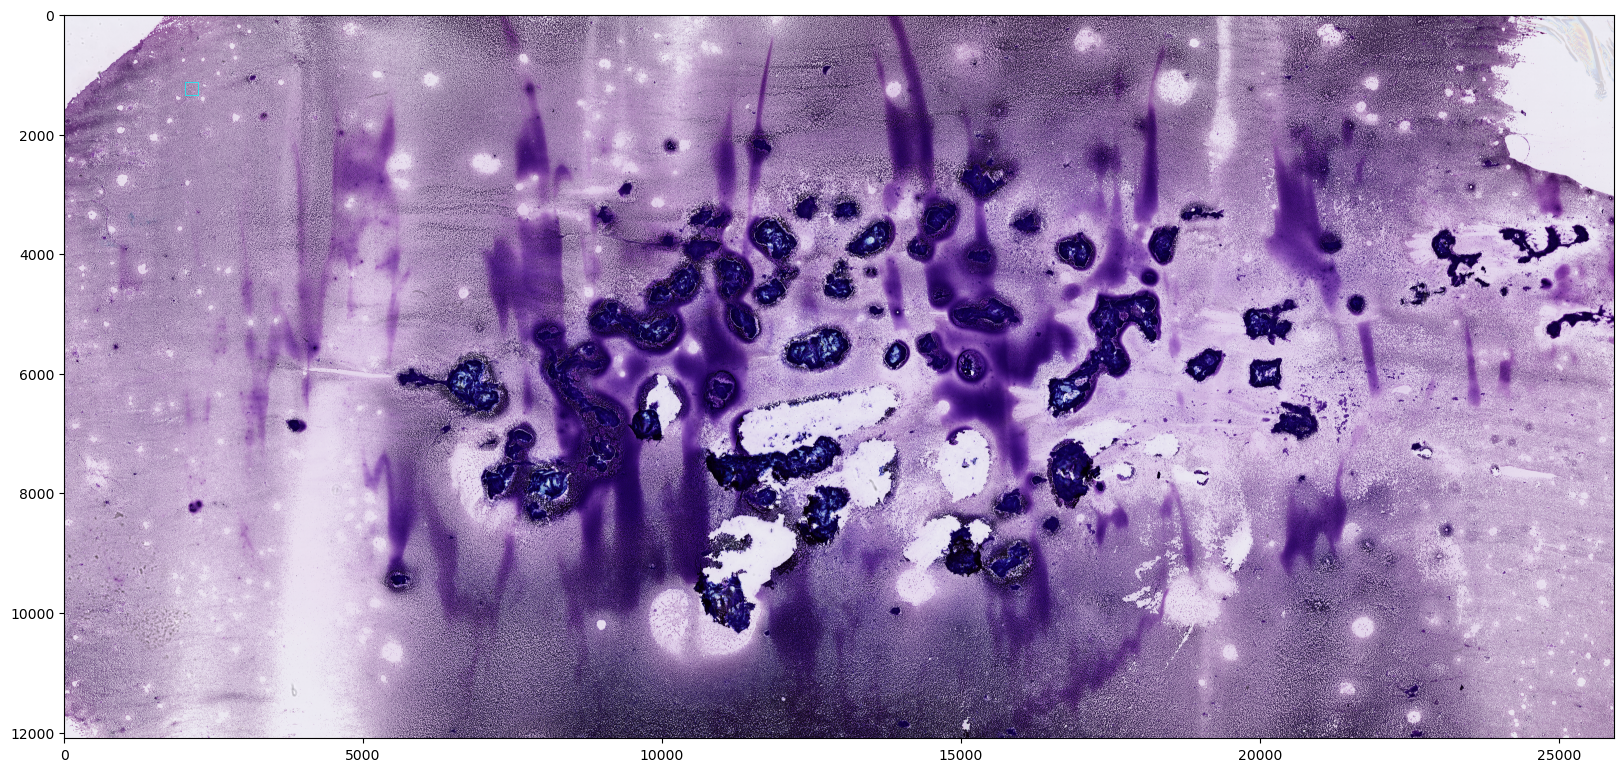

In [ ]:
def create_patches_from_highres_parquet(file_path):
    df = pd.read_parquet(file_path)
    patches = []

    for _, row in df.iterrows():
        x, y = row['x'], row['y']

        if 'refined_prediction' in row:
            prediction = row['refined_prediction']
        elif 'confirmed_prediction' in row:
            prediction = row['confirmed_prediction']
        else:
            continue  # skip if no known prediction field

        embedding = row['embedding'] if 'embedding' in row else None
        probabilities = row['probabilities'] if 'probabilities' in row else None

        patch = Patch(x, y, prediction, embedding, probabilities)
        patches.append(patch)

    return patches

def load_highres_patches_from_folder(folder_path):
    patches = []

    for file_name in os.listdir(folder_path):
        if file_name.endswith(".parquet"):
            file_path = os.path.join(folder_path, file_name)
            patches.extend(create_patches_from_highres_parquet(file_path))

    print(f"Number of loaded patches: {len(patches)}")
    return patches

# Display function
def run_visualization_for_high_res(
    high_res_folder="wsi_results_high_res",
    slide_base_path="C:/Users/lucas/AAA_MEMOIRE/Code_Memoire/img/database",
    save_folder="visualisations_highres",
    classes=["1", "2", "3", "41", "42", "51", "52", "54", "57"],
    level=4,
    patch_size=224
):
    os.makedirs(save_folder, exist_ok=True)

    for image_folder in os.listdir(high_res_folder):
        full_folder_path = os.path.join(high_res_folder, image_folder)

        if not os.path.isdir(full_folder_path):
            continue

        image_name = image_folder  # Example: "11C01217"
        slide_filename = f"{image_name}.ndpi"
        slide_path = os.path.join(slide_base_path, slide_filename)

        if not os.path.exists(slide_path):
            continue

        print(f"\nProcessing high-res for {image_name}...")

        patches = load_highres_patches_from_folder(full_folder_path)
        labels = [patch.prediction for patch in patches]

        output_img = os.path.join(save_folder, f"heatmap_highres_{image_name}.png")
        visualize_prediction_map(
            patches=patches,
            labels=labels,
            slide_path=slide_path,
            level=level,
            patch_size=patch_size,
            classes=classes,
            title=f"High-res Prediction Map - {image_name}",
            filename=output_img
        )
        print(f"High-res visualization saved: {output_img}")

# Run the high-res visualization
run_visualization_for_high_res(
    high_res_folder="../../Cytology-fine-tuning/wsi_results_high_res_sampling",
    slide_base_path="C:/Users/lucas/AAA_MEMOIRE/Code_Memoire/img/database",
    save_folder="visualisations_highres",
    level=2
)
